In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics

import numpy as np
import shutil
from random import shuffle
import os
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import random
from keras.preprocessing.image import ImageDataGenerator
import time

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

Using TensorFlow backend.


#### MOUNT GOOGLE DRIVE TO THE PROJECT DIRECTORY



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Extract the training and testing datasets



In [3]:
!cp  'drive/My Drive/datasets/MODEL1/model1.tar.gz' 'model1.tar.gz'
!tar -xvf  'model1.tar.gz' 

Streaming output truncated to the last 5000 lines.
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_40.54050254517096_40.54230361665938.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_40.801652028517545_40.80345301828673.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_40.81425894505862_40.816059930880016.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_40.87909407928082_40.88089504479551.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_41.00696122859242_41.008762154039246.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_41.042979630266906_41.04478054442266.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_41.09880770653381_41.100608603184696.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_41.36713507815293_41.36893589060661.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_41.392346401050474_41.394147205588006.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_41.66246076022465_41.6

#### GET THE LIST OF FILES IN THE TESTING DATASES



In [6]:
def get_test_dataset(PATH,categories):
    
    test  = dict()
    validate = dict()
    
    for i in categories:        
        test[i]  = os.listdir(f'{PATH}/{i}/')

    for i in test:
        print(f"test {i}: {len(test[i])}")
        
    return test

### SHOW SAMPLE IMAGES FOR EACH OF THE CATEGORIES

In [7]:
def show_sample_images(test,categories):
    for categorie in categories:
        sample_normal = random.sample(test[categorie],6)
        print(sample_normal)
        f,ax = plt.subplots(2,3,figsize=(15,9))

        for i in range(0,6):
            im = cv2.imread(f'{PATH}/{categorie}/{sample_normal[i]}')
            ax[i//3,i%3].imshow(im)
            ax[i//3,i%3].axis('off')
        f.suptitle(f'{categorie.upper()}')
        plt.show()

In [8]:
PATH = "MODEL1/test"
image_width = 128
image_height = 128
categories =  ['SAFE','ACCIDENTS']
test = get_test_dataset(PATH,categories)

test SAFE: 7584
test ACCIDENTS: 7584


['-7.827567297978168_-7.825325986163883_39.650704482700185_39.65250583171663.jpg', '-7.892565340592466_-7.8903240287781795_40.98174821306609_40.98354914641554.jpg', '-8.551511013992581_-8.549269702178295_40.0289754706706_40.03077670188551.jpg', '-7.957563383206764_-7.955322071392477_39.018396412646155_39.02019795791673.jpg', '-8.233244736363954_-8.231003424549668_37.19855218060497_37.20035428531068.jpg', '-9.120804214821252_-9.118562903006968_39.51740310109161_39.51920449155264.jpg']


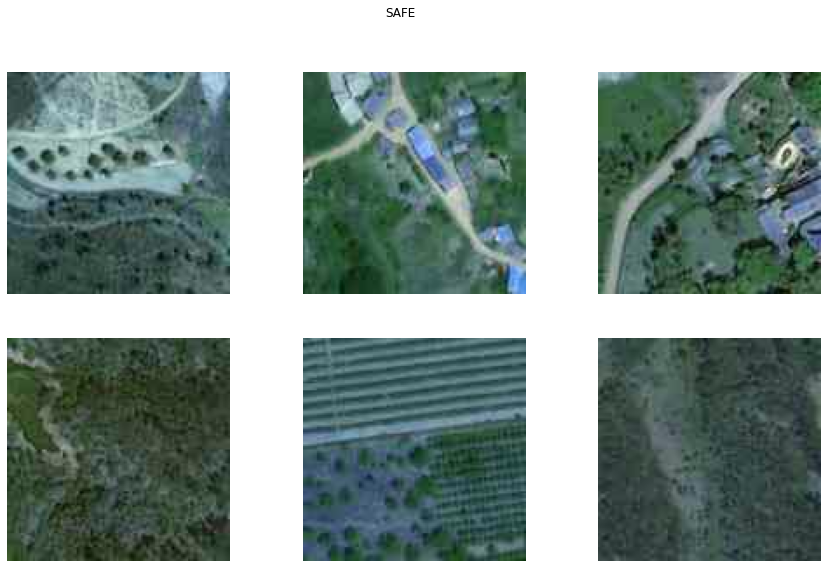

['-8.576165443949728_-8.573924132135442_41.172644006077924_41.17444487957039.jpg', '-9.149941268406973_-9.147699956592684_39.032808759188754_39.034610299995826.jpg', '-7.693088589121003_-7.690847277306715_37.33731263438456_37.33911469675039.jpg', '-8.152557511049654_-8.150316199235368_41.17444487957039_41.176245752497906.jpg', '-9.143217332964113_-9.140976021149829_39.01299177348702_39.0147933204313.jpg', '-7.4958531494638265_-7.493611837649539_40.12263874902744_40.12443995103107.jpg']


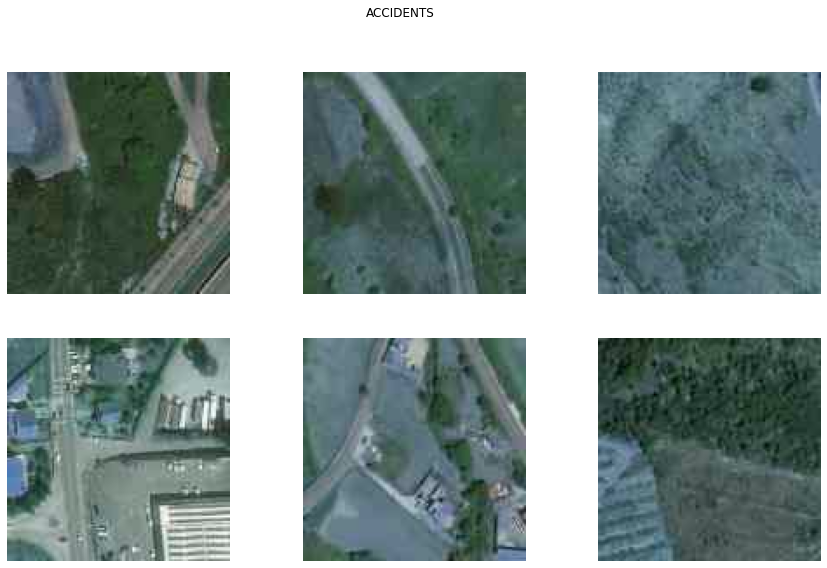

In [9]:
show_sample_images(test,categories)

#### USE GENERATORS TO GET A NUMPY ARRAY TO COMPUTE THE DIFFERNT METRICS USING THE SKLEARN LIBRARY

In [10]:
TEST_SET_COUNT = sum([len(os.listdir(f"{PATH}/{x}")) for x in categories]) 


test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(PATH,
                                            target_size=(image_width, image_height),
                                            batch_size=TEST_SET_COUNT,
                                            class_mode='categorical')

X_test, y_test = test_set.next()

Found 15168 images belonging to 2 classes.


In [12]:
test_set.class_indices

{'ACCIDENTS': 0, 'SAFE': 1}

#### GATHER THE TRAINING HISTORY AND TRAINED MODEL FOR A GIVEN MODEL

In [11]:
def get_past_history(MODEL_HISTORY):
  
  if not os.path.isfile(MODEL_HISTORY):
    return None 
  else:
    history = pd.read_csv(MODEL_HISTORY)
    return history

def get_total_history(past_history,new_history):
  
  history = pd.concat([past_history,new_history], axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
  return history

def get_past_model(MODEL_FILE):
  
  if not os.path.isfile(MODEL_FILE):
    
    return None 
  else:
    model = load_model(MODEL_FILE)
    return model


#### PLOT THE TRAINING HISTORY 

In [ ]:
def plot_training_history(history):
  plt.plot(history['categorical_accuracy'])
  plt.plot(history['val_categorical_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

#### NECESSARY SKLEARN IMPORTS

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### CREATE CONFUSION MATRIX AND COMPUTE METRICS 
###### METRICS USED:


*   accuracy
*   precision
*   recall
*   f1_score



In [ ]:
def create_confusion_matrix(y_true,y_predict):
  cm =confusion_matrix(y_true, y_predict)  
  print(cm)
  index = ['SAFE','ACCIDENTS']  
  columns = ['SAFE','ACCIDENTS']  
  cm_df = pd.DataFrame(cm,columns,index)                      
  plt.figure(figsize=(10,6))  
  sns.heatmap(cm_df, annot=True, fmt='g')

def compute_metrics(model,X_test,y_test,reverse_order=False):
  
  print(f"number of elements in testing dataset {len(y_test)}")

  if reverse_order:
    y_test = [np.argmax(x) for x in y_test]  
  
  else:
    y_test = [np.argmin(x) for x in y_test]

  y_predict = model.predict(X_test)
  
  start = time.time()

  y_predict = np.array([np.argmin(x) for x in y_predict])
  

  end = time.time()

  predict_time = end - start
  
  print(f"time {predict_time}")
  print(f"accuracy {accuracy_score(y_test,y_predict)}")

  print(f"precision {precision_score(y_test,y_predict)}")

  print(f"recall {recall_score(y_test,y_predict)}")

  print(f"f1_score {f1_score(y_test,y_predict)}")

  create_confusion_matrix(y_test,y_predict)

#### COMPUTE THE METRICS FOF THE MOBILENET MODEL WITHOUT TRANSFER LEARNING

In [ ]:
MODEL = "mobilenet_v2_5.hdf5"
TRAINED_MODEL = f"drive/My Drive/models/{MODEL}"
TRAINING_HISTORY = f"drive/My Drive/history/{MODEL}"
history = get_past_history(TRAINING_HISTORY)
model = get_past_model(TRAINED_MODEL)

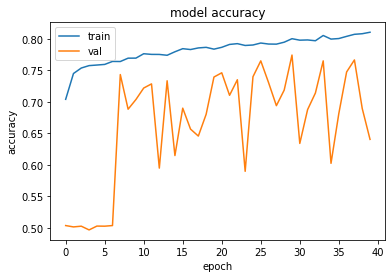

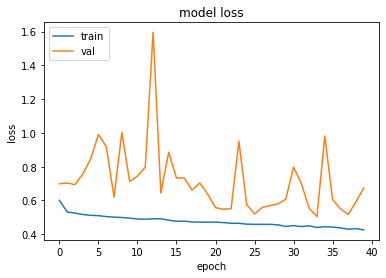

In [ ]:
plot_training_history(history)

number of elements in testing dataset 15168
time 0.028494596481323242
accuracy 0.6233517932489452
precision 0.827900455660708
recall 0.3114451476793249
f1_score 0.4526204848136438
[[7093  491]
 [5222 2362]]


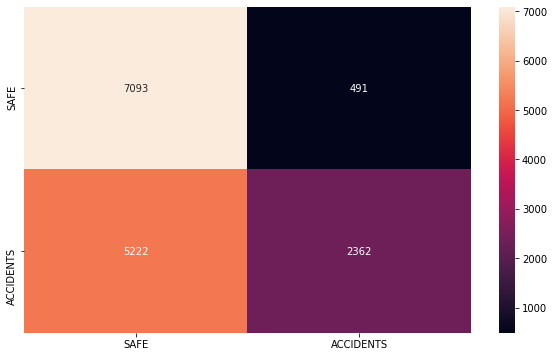

In [ ]:
compute_metrics(model,X_test,y_test,reverse_order=True)

#### COMPUTE THE METRICS FOF THE INCEPTION V3 MODEL WITHOUT TRANSFER LEARNING

---



In [ ]:
MODEL = "inceptionv3_2.hdf5"
TRAINED_MODEL = f"drive/My Drive/models/{MODEL}"
TRAINING_HISTORY = f"drive/My Drive/history/{MODEL}"
history = get_past_history(TRAINING_HISTORY)
model = get_past_model(TRAINED_MODEL)

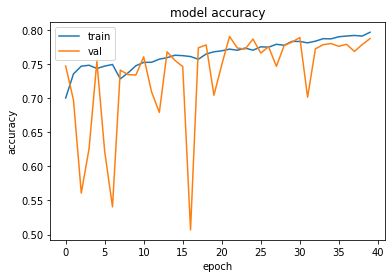

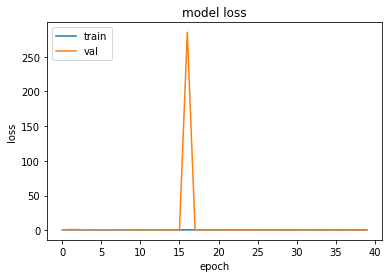

In [ ]:
plot_training_history(history)

number of elements in testing dataset 15168
time 0.031008243560791016
accuracy 0.7827004219409283
precision 0.8103647944412276
recall 0.7381329113924051
f1_score 0.7725641733370135
[[6274 1310]
 [1986 5598]]


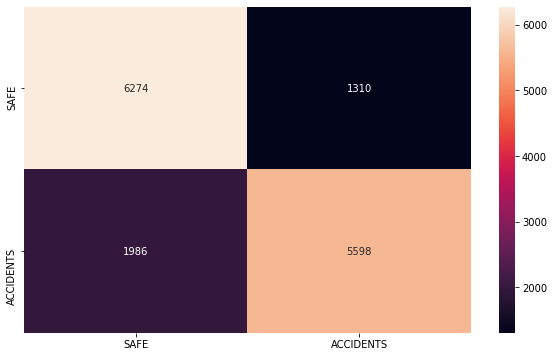

In [ ]:
compute_metrics(model,X_test,y_test)

#### COMPUTE THE METRICS FOF THE RESNET 50 MODEL WITHOUT TRANSFER LEARNING

In [ ]:
MODEL = "resnet50_dataset1.hdf5"
TRAINED_MODEL = f"drive/My Drive/models/{MODEL}"
TRAINING_HISTORY = f"drive/My Drive/history/{MODEL}"
history = get_past_history(TRAINING_HISTORY)
model = get_past_model(TRAINED_MODEL)

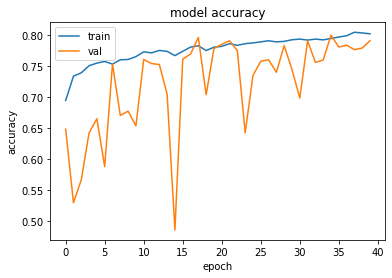

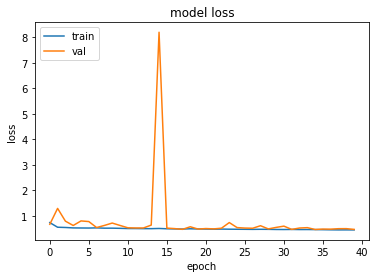

In [ ]:
plot_training_history(history)

number of elements in testing dataset 15168
time 0.025661468505859375
accuracy 0.7885021097046413
precision 0.7826143115474038
recall 0.798918776371308
f1_score 0.790682500326243
[[5901 1683]
 [1525 6059]]


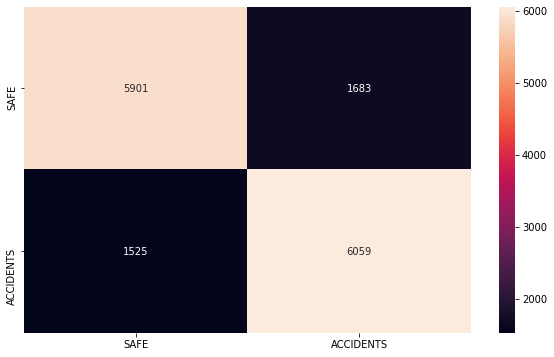

In [ ]:
compute_metrics(model,X_test,y_test,reverse_order=True)

####  COMPUTE THE METRICS FOF THE INCEPTION V3 MODEL WITH TRANSFER LEARNING


In [ ]:
MODEL = "inceptionv3_tl.hdf5"
TRAINED_MODEL = f"drive/My Drive/models/{MODEL}"
TRAINING_HISTORY = f"drive/My Drive/history/{MODEL}"
history = get_past_history(TRAINING_HISTORY)
model = get_past_model(TRAINED_MODEL)

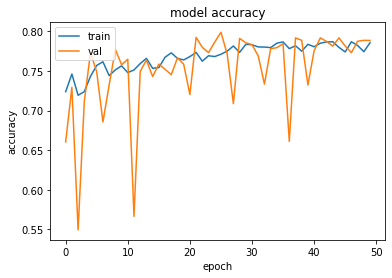

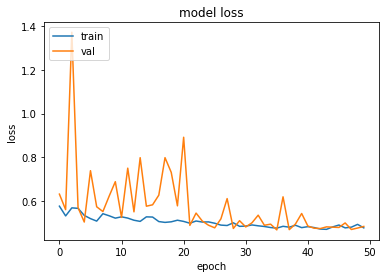

In [ ]:
plot_training_history(history)

number of elements in testing dataset 15168
time 0.026932239532470703
accuracy 0.7934467299578059
precision 0.7737055712704465
recall 0.8295094936708861
f1_score 0.8006363347120586
[[5744 1840]
 [1293 6291]]


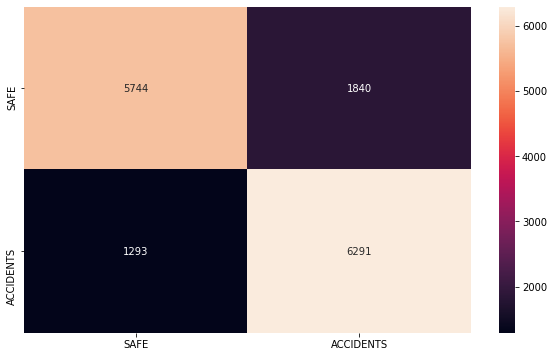

In [ ]:
compute_metrics(model,X_test,y_test,reverse_order=True)